# Unlock the Secret to Effortlessly Calculating Conditional Probabilities From Any DataFrame in Just 3 Lines of Code

## How to write a simple Python function that will calculate conditional probabilities directly from any DataFrame using notation like p(exam=1 | study=1)

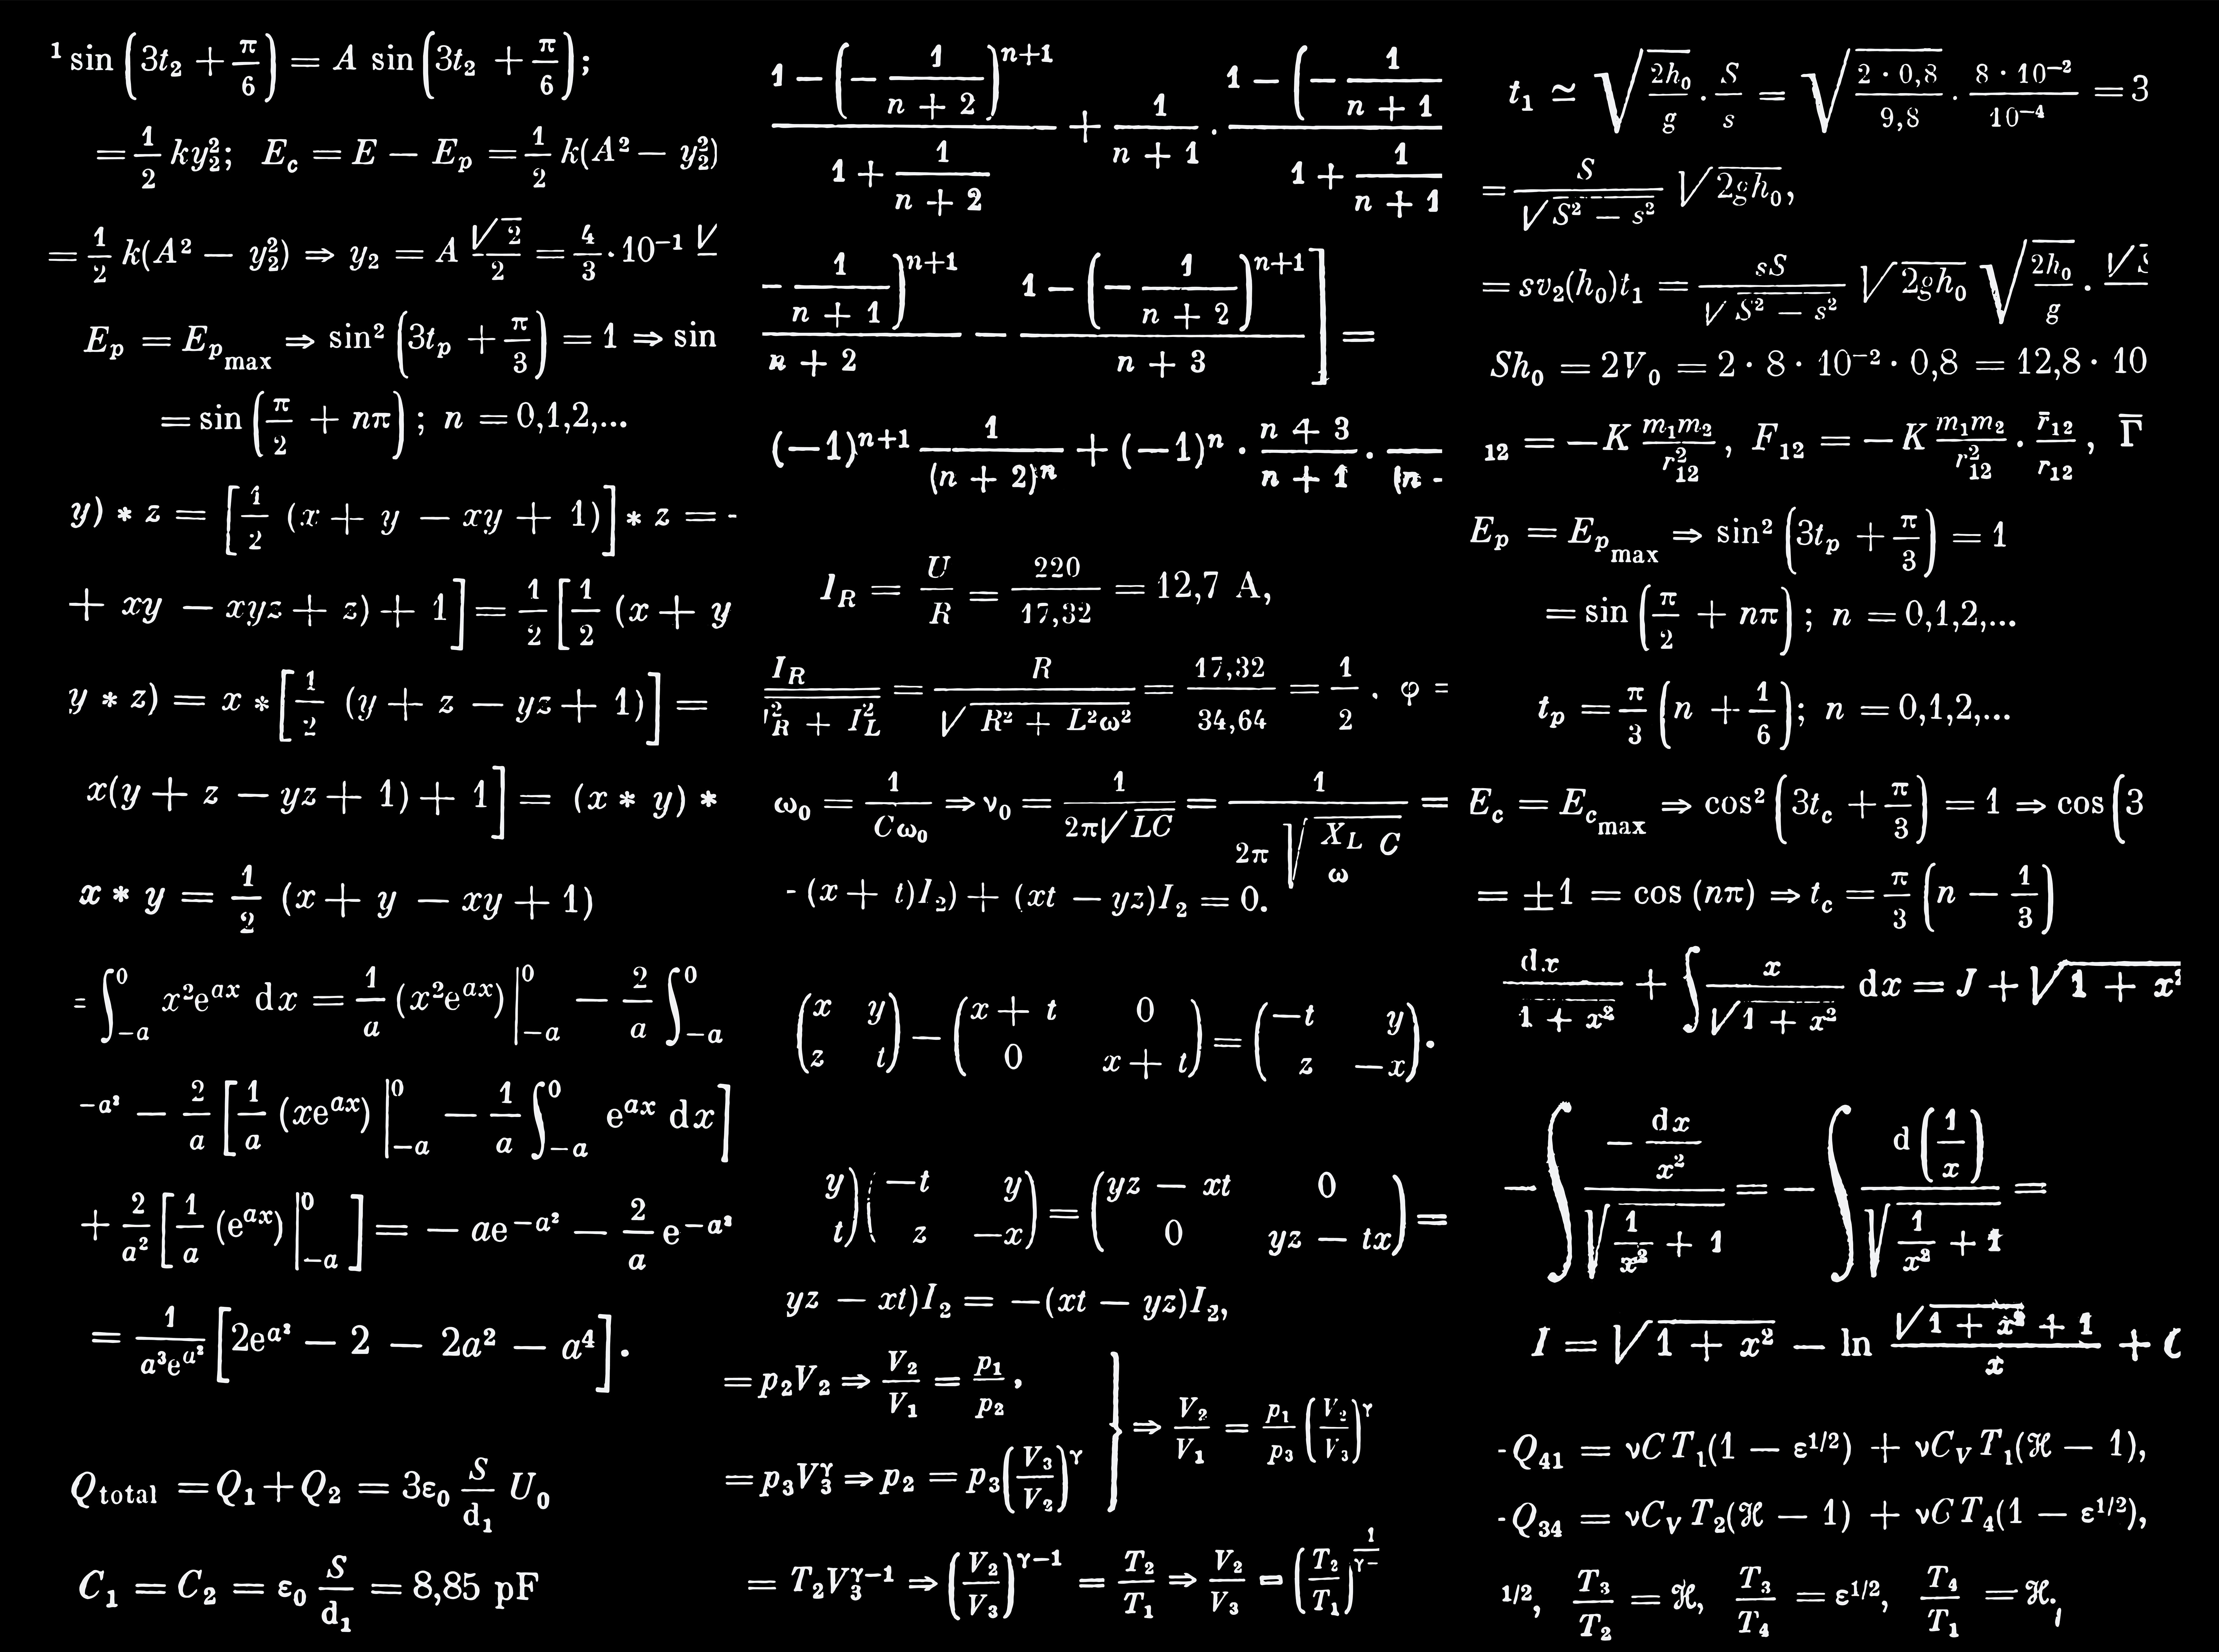
Photo by <a href="https://unsplash.com/@dancristianpaduret?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Dan Cristian Pădureț</a> on <a href="https://unsplash.com/photos/xJLN32FO7AY?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

## Background
As I have continued to delve into causal inference I reached a stage where I needed to be able to construct formulas that use complex combinations of conditional probabilities and the code was starting to be difficult to read and maintain. This led to me  developing a simple way to calculate conditional probabilities.

By the end of this article you will be equipped with a short Python function that can apply a conditional probability directly to a any pandas ``DataFrame`` and return the result.

## A Recap
Conditional probability is the probability of an event occurring given that another event has already occurred. The notation $P(A \mid B)$ can be understood as the probability (P) of event A given (|) that event B has already occured. 

To extend this one step forward the notation $P(A\mid B,C)$ means the probability of event A given that both event B and event C have already occured. 

## An Example
We all know that if a fair coin is tossed twice the probability of getting two heads is 0.25 because the probability of the first event (tossing the first coin and getting ahead) is 0.5 multiplied by the probability of the second event (tossing the second coin and getting a head), also 0.5 i.e. 0.5 x 0.5 = 0.25.

The simple multiplication works when the two events are completely independent of each other i.e. there is no way that the result of the first coin toss can impact the second so before we perform the two events the probability of two heads is 0.25.

However, not all events are independent and this is best explained using an example ...

Here is a table of synthetic data representing a fictitious sample of 800 people where whether they study or not and whether they pass an exam or not has been observed and recorded ...

In [5]:
import sys
sys.path.insert(1, r'C:\Users\GHarrison\OneDrive - Lincoln College\Python Projects\Data Science\Utilities')

from Causal.lib.synthetic_utils import BinaryDataGenerator

import pandas as pd

generator = BinaryDataGenerator(population_size=800, columns=["study", "learning", "exam"], random_state=42)
generator.set_values(col_name="study", frac=0.5)
generator.set_values(col_name="learning", frac=0.05, condition=generator.data["study"]==0)
generator.set_values(col_name="learning", frac=0.95, condition=generator.data["study"]==1)
generator.set_values(col_name="exam", frac=0.15, condition=((generator.data["study"]==1) & (generator.data["learning"]==1)))
generator.set_values(col_name="exam", frac=0.1, condition=((generator.data["study"]==1) & (generator.data["learning"]==0)))
generator.set_values(col_name="exam", frac=0.95, condition=((generator.data["study"]==0) & (generator.data["learning"]==1)))
generator.set_values(col_name="exam", frac=0.9, condition=((generator.data["study"]==0) & (generator.data["learning"]==0)))
df_studying = generator.data

df_summary = df_studying[["study", "exam"]].groupby(["exam"]).value_counts().reset_index()
df_summary.rename(columns={0: "count"}, inplace=True)
df_summary

,exam,study,count
0,0,1,341
1,0,0,39
2,1,0,361
3,1,1,59


The probability of passing the exam (exam=1) is as follows -
$$p(exam=1) = \frac{(361+59)} {800} = \frac {420} {800} = 0.525$$

How about if we ask the following question:

One of the test subjects is selected at random and it is found that they studied (study=1). What is the probability that they passed the exam (exam=1)?

These probabilities are not independent like the coin tossing because we already know that the chosen subject studied. The answer to this question can be expressed as follows -

$$
p(exam=1 | study=1)
$$

i.e. the what is probability that exam = 1 given that study = 1?

There are two ways to calculate this result, the intuitive way and the probabilistic way. 

## The Intiutive Way
It is easy to see that there are 400 studiers (341 + 59) by looking for rows in the summary table where study = 1 - 

In [7]:
df_summary[df_summary["study"]==1]

,exam,study,count
0,0,1,341
3,1,1,59


If we have already selected a studier, they must have come from this part of the sample. Of these 400 it is easy to see that 59 pass the exam, so ...

$$P(exam=1 \mid study=1) = \frac{59} {(341 + 59)} = \frac {59} {400} = 0.1475$$

You may have noticed that a 14.8% pass rate is not very high, but bear with me on this - the data set is being set up for a future article where the true effect of studying will be made clear using causal inference.

## The Mathematical Way

The formula for calculating the conditional probability of an event A given the probability of another event B whose outcome is already known is as follows -

$$
P(A \mid B) = \frac {P(A\ and\ B)} {P(B)} = \frac {P({A} \cap {B})} {P(B)}
$$


Note - the notation P(A|B) can be read as - the conditional probability or event A "given" event B.

Personally I find this to be less intuitive that the first solution as I can easily visualise what is going on inside the ``DataFrame`` of values but this way does have a big advantage. If you only have access to the probabilities and not to all of the underlying data then the "Intuitive Way" is not an option.

Consider the following which is the same summary but with the probabilities instead of the counts ...

In [8]:
df_summary_prob = df_summary.copy(deep=True)
df_summary_prob["prob"] = df_summary_prob["count"] / df_studying.shape[0]
df_summary_prob.drop(columns=["count"], inplace=True)
df_summary_prob

,exam,study,prob
0,0,1,0.42625
1,0,0,0.04875
2,1,0,0.45125
3,1,1,0.07375


Now p(exam=1 | study=1) can be calculated as follows -

$$
P(exam=1 \mid study=1) = \\\frac {P(exam=1, study=1)} {P(study=1)} = \frac {0.07375} {0.42625 + 0.07375} = \frac {0.07375} {0.5} = 0.1475
$$

Note that P(exam=1, study=1) can be read as "probability of exam=1 <b>and</b> study=1" and is equivalent to P(exam=1 $\cap$ study=1)

## The Python Function Solution
Given the explanation of conditional probabilities, the objective now is to develop a Python function that can take all of the pain away and just work them out for any pandas ``DataFrame``.

The first thing we need are some test data. I have created a synthetic dataset using my ``BinaryDataGenerator`` class. If you would like the full source code, head over to this article - 
- https://towardsdatascience.com/how-to-generate-synthetic-data-for-any-causal-inference-project-in-less-than-10-lines-of-code-158688a89349.

In [9]:
generator = BinaryDataGenerator(population_size=800, columns=["study", "learning", "exam"], random_state=42)
generator.set_values(col_name="study", frac=0.5)
generator.set_values(col_name="learning", frac=0.05, condition=generator.data["study"]==0)
generator.set_values(col_name="learning", frac=0.95, condition=generator.data["study"]==1)
generator.set_values(col_name="exam", frac=0.15, condition=((generator.data["study"]==1) & (generator.data["learning"]==1)))
generator.set_values(col_name="exam", frac=0.1, condition=((generator.data["study"]==1) & (generator.data["learning"]==0)))
generator.set_values(col_name="exam", frac=0.95, condition=((generator.data["study"]==0) & (generator.data["learning"]==1)))
generator.set_values(col_name="exam", frac=0.9, condition=((generator.data["study"]==0) & (generator.data["learning"]==0)))
df_studying = generator.data
df_studying

,study,learning,exam
0,1,1,1
1,0,0,1
2,1,1,0
3,1,1,0
4,0,0,1
...,...,...,...
795,1,1,0
796,1,1,0
797,0,0,1
798,1,0,0


## Version 1: Basic Function

The most basic version of the function, implemented using the promised "3 lines of code" is as follows -

In [10]:
def calc_cond_prob(df_data: pd.DataFrame, outcome : tuple = None, events : dict = {}) -> float:

    for feature, value in events.items():
        df_data = df_data[df_data[feature] == value]

    prob = df_data[df_data[outcome[0]]==outcome[1]].shape[0] / df_data.shape[0]

    return prob

calc_cond_prob(df_data=df_studying, outcome=("exam",1), events={"study": 1})

0.1475

## Version 2: Basic Function Plus LaTeX Output

However, I soon got bored with all the ``print`` statements to show the results which led to the second version which can optionally output a LaTeX representation of the calculation ...

In [12]:
from IPython.display import Math

def calc_cond_prob(df_data: pd.DataFrame, outcome : tuple, events : dict, display_latex : bool = False) -> float:

    for feature, value in events.items():
        df_data = df_data[df_data[feature] == value]

    prob = df_data[df_data[outcome[0]]==outcome[1]].shape[0] / df_data.shape[0]
    
    if display_latex:
        mid_char : str = r"\mid"
        display(Math(f"p({outcome[0]}={outcome[1]} {'' if len(events) == 0 else mid_char} {', '.join('{}={}'.format(k,v) for k,v in events.items())}) = {prob}"))

    return prob

calc_cond_prob(df_data=df_studying, outcome=("exam",1), events={"study": 1}, display_latex=True)
calc_cond_prob(df_data=df_studying, outcome=("exam",1), events={"study": 1, "learning": 1}, display_latex=True)
print("")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Version 3: Advanced Function
Having got this far I really wanted a final version where I could just say P(exam=1 | study=1) directly and get the result, but I also wanted to retain ``outcome`` and ``events`` as optional parameters so I could choose with method to use ...

In [13]:
from typing import Tuple
from IPython.display import Math

import re
import ast

def __int_float_str(v : any) -> any:
    try:
        return ast.literal_eval(v)
    except ValueError:
        return v

def __extract_outcome_events(cond_prob: str) -> Tuple[tuple, dict]:
    cond_prob = cond_prob.replace(" ", "")
    outcome = re.findall(r'(?i)[p]\((\w+)=(\d+)', cond_prob)[0]
    events = {k:__int_float_str(v) for k,v in re.findall(r'(\w+)=(\w+)', re.search(r'(?i)[p]\(([^|]+)\|?(.*)', cond_prob).group(2))}

    return (outcome[0], __int_float_str(outcome[1])), events

def calc_cond_prob(df_data: pd.DataFrame, cond_prob : str = None, outcome : tuple = None, events : dict = {}, display_latex : bool = False) -> float:
    """Calculates a conditional probability from the values in a DataFrame

    Args:
        df_data (pd.DataFrame): The DataFrame being used
        cond_prob (str): The conditional probaility being calculated, for example p(A=1|B=1)
        outcome (tuple, optional): If cond_prob is not passed the outcome can be specified directly. Defaults to None.
        events (dict, optional): If cond_prob is not passed the events can be specified directly. Defaults to None.
        display_latex (bool, optional): If True the a Latex representation of the conditional probability is displayed. Defaults to False.

    Returns:
        float: The calculated conditional probability
    """
    if outcome is None and len(events) == 0:
        outcome, events = __extract_outcome_events(cond_prob)

    for feature, value in events.items():
        df_data = df_data[df_data[feature] == value]

    prob = df_data[df_data[outcome[0]]==outcome[1]].shape[0] / df_data.shape[0]

    if display_latex:
        mid_char : str = r"\mid"
        display(Math(f"p({outcome[0]}={outcome[1]} {'' if len(events) == 0 else mid_char} {', '.join('{}={}'.format(k,v) for k,v in events.items())}) = {prob}"))

    return prob

calc_cond_prob(df_data=df_studying, cond_prob="p(exam=1|study=1)", display_latex=True)
calc_cond_prob(df_data=df_studying, cond_prob="p(exam=1|study=1, learning=1)", display_latex=True)
print("")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Conclusion
Conditional probabilities are very useful in a range of statistical and machine learning solutions but there is no easy, readable and repeatable way to calculate them from a pandas ``DataFrame``.

This article has explained what conditional proabilities are, given an example and then provided all the source code for a Python function that can take any ``DataFrame`` and then calculate and display the result.